In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import fibsem
from fibsem.imaging import masks
from fibsem.imaging import utils   
from autoscript_sdb_microscope_client.structures import AdornedImage
from PIL import Image
import logging
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage import data
from skimage import filters
from skimage.color import rgb2gray
import imageio
import cv2
import glob
import itertools
import pandas as pd
from pprint import pprint
import plotly.express as px
import scipy
import statsmodels
import ipywidgets
from dataclasses import dataclass
import scipy
from skimage.feature import match_template

In [2]:
def xcorr(
    img1: np.ndarray, 
    img2: np.ndarray, 
    use_mask: bool = True, 
    use_threshold: bool = True) -> np.ndarray:

    if img1.data.shape != img2.data.shape:
        err = f"Image 1 {img1.data.shape} and Image 2 {img2.data.shape} need to have the same shape"
        logging.error(err)
        raise ValueError(err)

    if use_mask:
        # Create Fourier Transform WITH Bandpass Filter
        pixelsize_img1 = img1.data.shape
        pixelsize_img2 = img2.data.shape
        img1_mask = masks.create_bandpass_mask(pixelsize_img1, 100, 4, 3)
        img2_mask = masks.create_bandpass_mask(pixelsize_img2, 100, 4, 3)
        img1fft = np.fft.ifftshift(img1_mask * np.fft.fftshift(np.fft.fft2(img1.data)))
        img2fft = np.fft.ifftshift(img2_mask * np.fft.fftshift(np.fft.fft2(img2.data)))
        assert img1_mask is not None, "Mask1 can not be None when using a Mask"
        assert img2_mask is not None, "Mask2 can not be None when using a Mask"

    else:
        # Create Fourier Transform
        img1fft = np.fft.ifftshift(np.fft.fftshift(np.fft.fft2(img1.data)))
        img2fft = np.fft.ifftshift(np.fft.fftshift(np.fft.fft2(img2.data)))

    # Do some shady normalization(?)
    n_pixels1 = img1.data.shape[0] * img1.data.shape[1]
    img1fft[0, 0] = 0
    tmp = img1fft * np. conj(img1fft)
    img1fft = n_pixels1 * img1fft / np.sqrt(tmp.sum())
    

    n_pixels2 = img2.data.shape[0] * img2.data.shape[1]
    img2fft[0, 0] = 0
    tmp = img2fft * np. conj(img2fft)
    img2fft = n_pixels2 * img2fft / np.sqrt(tmp.sum())


    if use_threshold:
        # Create threshold (Otsu's method) in abs Space
        abs1 = np.fft.fftshift(np.fft.ifftshift(np.fft.ifft2(img1fft)))
        abs2 = np.fft.fftshift(np.fft.ifftshift(np.fft.ifft2(img2fft)))
        otsu1 = filters.threshold_otsu(np.abs(abs1))
        otsu2 = filters.threshold_otsu(np.abs(abs2))

        # Create segmented binary Img
        binary1 = (abs1 > otsu1)*1
        binary2 = (abs2 > otsu2)*1
        
        # Back to Fourier Space for cross-correlation
        fft1 = np.fft.ifftshift(np.fft.fftshift(np.fft.fft2(binary1)))
        fft2 = np.fft.ifftshift(np.fft.fftshift(np.fft.fft2(binary2)))

        # Cross-correlate the two images
        corr = np.real(np.fft.fftshift(np.fft.ifft2(fft1 * np.conj(fft2))))

        # Cross-correlation center and shift from center
        maxX, maxY = np.unravel_index(np.argmax(corr), corr.shape)
        cen = np.asarray(corr.shape) / 2
        err = np.array(cen - [maxX, maxY], int)
        valMax = np.amax(corr)
        return corr, err

    else:
        # Cross-correlate the two images
        corr = np.real(np.fft.fftshift(np.fft.ifft2(img1fft * np.conj(img2fft))))
       
        # Cross-correlation center and shift from center
        maxX, maxY = np.unravel_index(np.argmax(corr), corr.shape)
        cen = np.asarray(corr.shape) / 2
        err = np.array(cen - [maxX, maxY], int)
        valMax = np.amax(corr)
        return corr, err

In [3]:
# Create dictionary for IB images, sort by grid position, field with (img stack), and corresponding name/img position
dict1 = {}
dict2 = {}
dict3 = {}
grid_poses = ["000.000", "000.001", "000.002", "001.000", "001.001", "001.002", "002.000", "002.001", "002.002"]
hfws = ["8", "15", "20", "30", "50"]
names = ["base", "diag_down", "diag_up", "start"]

for grid_pos in grid_poses:
    dict1[grid_pos] = {}
    dict2[grid_pos] = {}
    for hfw in hfws:
        dict1[grid_pos][hfw] = {}
        dict2[grid_pos][hfw] = {}
        for name in names:
            fname1 = glob.glob(f"../../mapping_2022-09-27.01-18-18PM/{grid_pos}/{name}*{hfw}*.tif")[0]
            fname2 = glob.glob(f"../../mapping_2022-09-27.02-59-50PM/{grid_pos}/{name}*{hfw}*.tif")[0]
    
            img1 = mpimg.imread(fname1)
            img2 = mpimg.imread(fname2)
            dict1[grid_pos][hfw][name] = img1
            dict2[grid_pos][hfw][name] = img2

for grid_pos in ["000.000", "000.001", "001.000", "001.001"]:
    dict3[grid_pos] = {}
    for hfw in hfws:
        dict3[grid_pos][hfw] = {}
        for name in names:
            fname3 = glob.glob(f"../../mapping_2022-09-27.04-26-12PM/{grid_pos}/{name}*{hfw}*.tif")[0]
            img3 = mpimg.imread(fname3)
            dict3[grid_pos][hfw][name] = img3

# Create dictionary for Fluorescence images, sort by grid position (tile) and exposure times
# Additionally, transpose and crop the image array to the right IB image size.
fluor1 = {}
fluor2 = {}
fluor3 = {}
tiles = ["0.0", "0.1", "0.2", "1.0", "1.1", "1.2", "2.0", "2.1", "2.2"]
exposures = ["350", "500"]
for tile in tiles:
    fluor1[tile] = {}
    fluor2[tile] = {}
    for exposure in exposures:
        file1 = glob.glob(f"../../mapping_2022-09-27.01-18-18PM/fluro/{tile}*{exposure}*.tiff")[0]
        file2 = glob.glob(f"../../mapping_2022-09-27.02-59-50PM/fluro/{tile}*{exposure}*.tiff")[0]
        img1 = mpimg.imread(file1)
        img2 = mpimg.imread(file2)
        fluor1[tile][exposure] = np.flip(img1[512:1536, 256:1792], axis=0)
        fluor2[tile][exposure] = np.flip(img2[512:1536, 256:1792], axis=0)

for tile in ["0.0", "0.1", "1.0", "1.1"]:
    fluor3[tile] = {}
    for exposure in exposures:
        file3 = glob.glob(f"../../mapping_2022-09-27.04-26-12PM/fluro/{tile}*{exposure}*.tiff")[0]
        img3 = mpimg.imread(file3)
        fluor3[tile][exposure] = img3.T[512:1536, 256:1792]

In [13]:
fft = np.fft.fftshift(np.fft.fft2(fluor2["0.0"]["350"]))
mat2 = np.ndarray((972, 1458), dtype=np.complex128)
mat2[:,:] = fft[26:26+972, 39:39+1458]

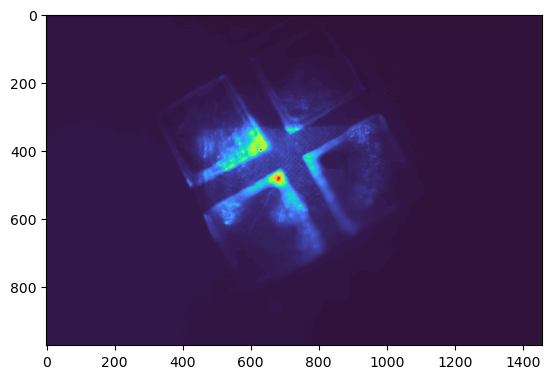

In [37]:
def normalize(image:np.ndarray) -> np.ndarray:
    mean, std = cv2.meanStdDev(image)
    norm = (image - mean) / std
    zero_array = np.zeros(norm.shape)
    final_img = cv2.normalize(norm,  zero_array, 0, 1, cv2.NORM_MINMAX)
    return final_img

def circ_mask(image:np.ndarray, mask_radius:int):
    zero_array = np.zeros(image.shape)
    mask = cv2.circle(zero_array, (768, 512), mask_radius, (1, 1, 1), -1) 
    smooth_mask = ndi.gaussian_filter(mask, 3)
    masked = image * smooth_mask
    return masked

ib_normalized1 = []
fl_normalized1 = []
normalized_corr1 = []
normalized_err1 = []
for i, j, k in zip(grid_poses, tiles, range(9)):
    ib_normalized1.append(circ_mask(normalize(dict2[i]["50"]["start"]), mask_radius=400))
    fl_normalized1.append(circ_mask(normalize(fluor2[j]["350"]), mask_radius=400))
    corr1, err1 = xcorr(ib_normalized1[k], fl_normalized1[k], False, False)
    normalized_corr1.append(corr1)
    normalized_err1.append(err1)

ib_normalized2 = []
fl_normalized2 = []
normalized_corr2 = []
normalized_err2 = []
for i, j, k in zip((["000.000", "000.001", "001.000", "001.001"]), ["0.0", "0.1", "1.0", "1.1"], range(4)):
    ib_normalized2.append(circ_mask(normalize(dict3[i]["50"]["start"]), mask_radius=400))
    fl_normalized2.append(circ_mask(normalize(fluor3[j]["350"]), mask_radius=400))
    corr2, err2 = xcorr(ib_normalized2[k], fl_normalized2[k], False, False)
    normalized_corr2.append(corr2)
    normalized_err2.append(err2)

ib_normalized = ib_normalized1 + ib_normalized2
fl_normalized = fl_normalized1 + fl_normalized2
normalized_corr = normalized_corr1 + normalized_corr2
normalized_err = normalized_err1 + normalized_err2

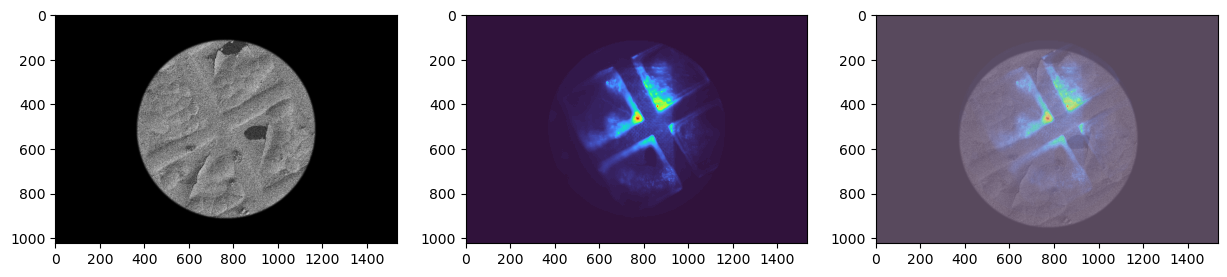

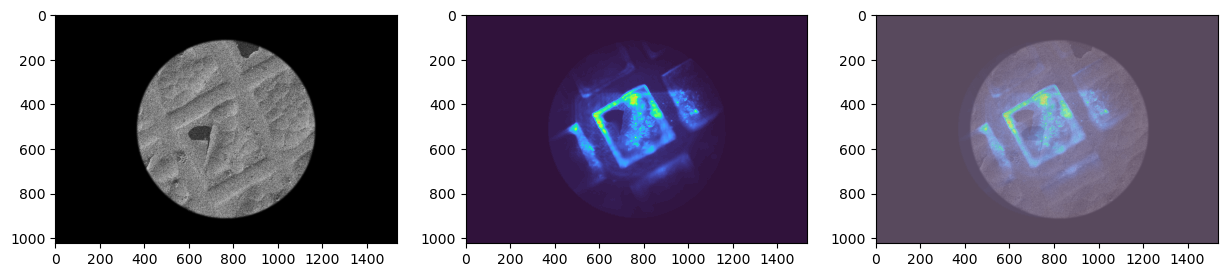

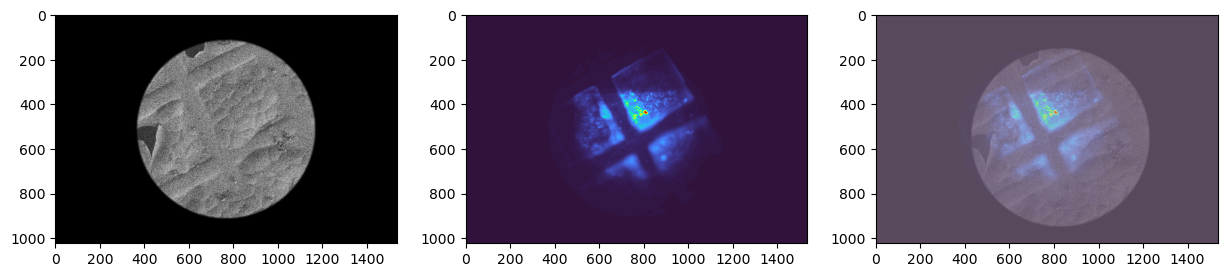

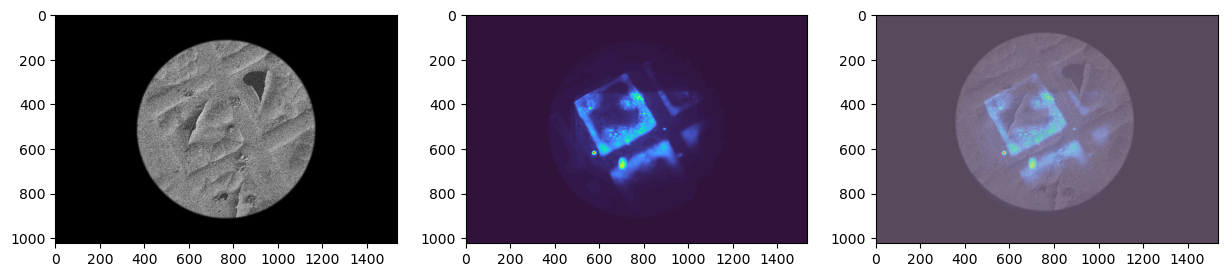

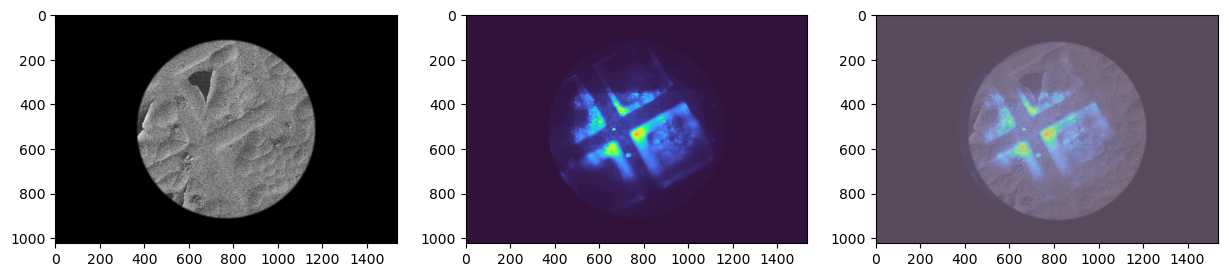

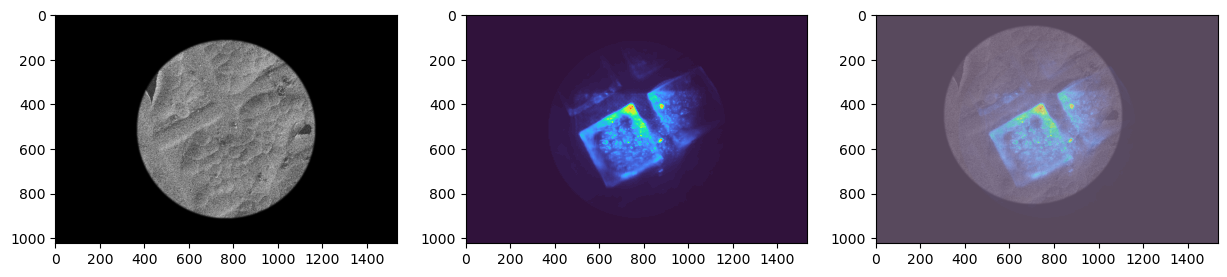

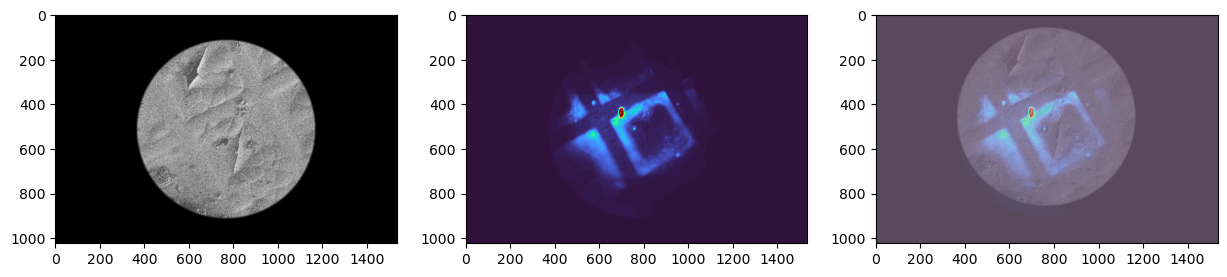

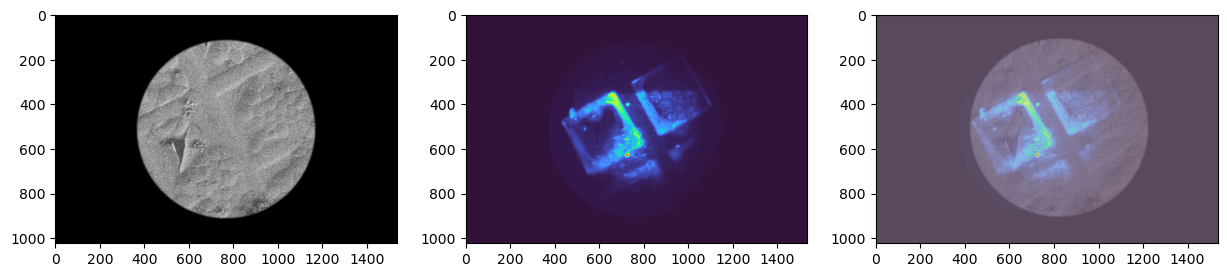

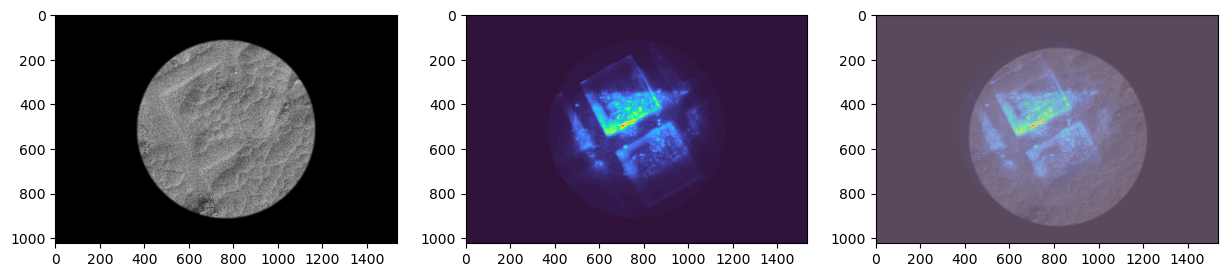

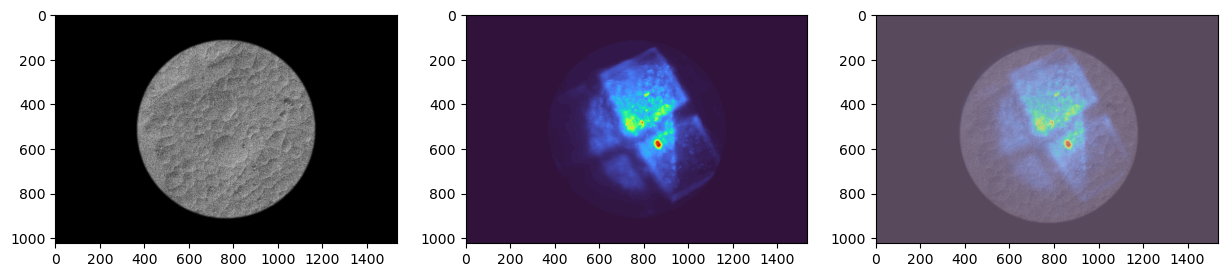

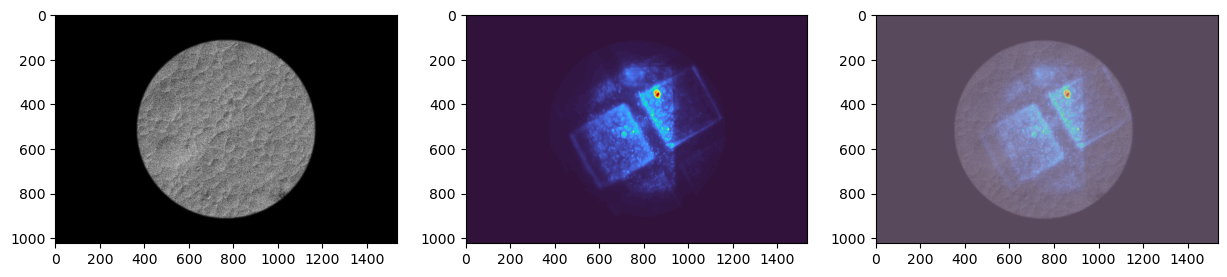

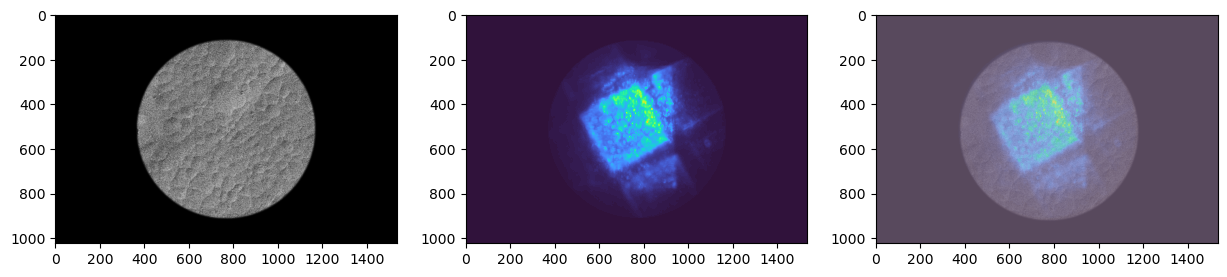

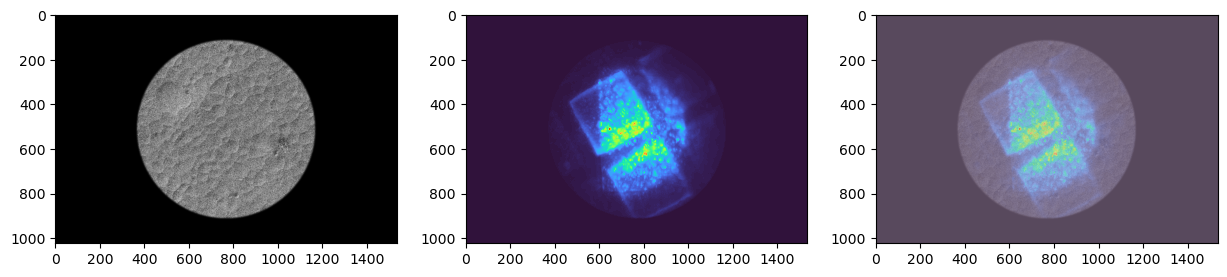

In [38]:
for i in range(13):
    fig, ax = plt.subplots(1,3,figsize=(15,15))
    ax[0].imshow(ib_normalized[i], cmap='gray')
    ax[1].imshow(fl_normalized[i], cmap='turbo')
    ax[2].imshow(np.roll(ib_normalized[i], shift=(-normalized_err[i]), axis=(0,1)), alpha=0.5, cmap='gray')
    ax[2].imshow(fl_normalized[i], alpha=0.5, cmap='turbo')

In [45]:
normalized_outline_mask = masks.create_bandpass_mask((1024, 1536), 50, 5, 5)

ib_outline = []
fl_outline = []
for i in range(13):
    temp1 = (normalized_outline_mask * np.fft.fftshift(np.fft.fft2(ib_normalized[i])))
    temp2 = (normalized_outline_mask * np.fft.fftshift(np.fft.fft2(fl_normalized[i])))
    ib_outline.append(np.abs(np.fft.ifft2(temp1)))
    fl_outline.append(np.abs(np.fft.ifft2(temp2)))

no_mask_corr = []
no_mask_err = []
outline_corr = []
outline_err = []
for i in range(13):
    corr1, err1 = xcorr(ib_outline[i], fl_outline[i], False, False)
    outline_corr.append(corr1)
    outline_err.append(err1)

In [47]:
for i in range(13):
    fig, ax = plt.subplots(1,3, figsize=(15,15))
    ax[0].imshow(ib_outline[i], cmap='gray')
    ax[1].imshow(fl_outline[i], cmap='turbo')
    ax[2].imshow(ib_normalized[i], alpha=0.5, cmap='gray')
    ax[2].imshow(np.roll(fl_outline[i], shift=(-outline_err[i]), axis=(0,1)), alpha=0.5, cmap='turbo')